In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
observation = pd.read_csv("./094/observation.csv", sep='\t', engine="python")

In [3]:
y = observation['oximetry'].values
X = observation.drop(columns=['oximetry'], axis=1).values
feature_names = observation.drop(columns=['oximetry'], axis=1).columns

In [4]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.impute import SimpleImputer

quantile_features = [20, 13]
scaled_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21]

qt = QuantileTransformer(output_distribution='normal', random_state=42, n_quantiles=2)
scaler = StandardScaler()
imputer = SimpleImputer(strategy="median")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
imputer.fit(X_train)

X_train_imp = imputer.transform(X_train)
X_test_imp  = imputer.transform(X_test)

qt.fit(X_train_imp[quantile_features])
scaler.fit(X_train_imp[scaled_features])

X_train_tr = X_train_imp.copy()
X_test_tr  = X_test_imp.copy()

X_train_tr[quantile_features] = qt.transform(X_train_imp[quantile_features])
X_test_tr[quantile_features]  = qt.transform(X_test_imp[quantile_features])

X_train_tr[scaled_features] = scaler.transform(X_train_imp[scaled_features])
X_test_tr[scaled_features]  = scaler.transform(X_test_imp[scaled_features])

## Functions

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

results = []

def print_metrics(name, y_true, y_pred):
    print(f"=== {name} ===")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall (macro):   ", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print()

def evaluate_model(name, y_train, y_train_pred, y_test, y_test_pred, average='binary'):
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    prec_train = precision_score(y_train, y_train_pred, average=average)
    prec_test = precision_score(y_test, y_test_pred, average=average)

    rec_train = recall_score(y_train, y_train_pred, average=average)
    rec_test = recall_score(y_test, y_test_pred, average=average)

    return {
        "model": name,
        "accuracy_train": acc_train,
        "precision_train": prec_train,
        "recall_train": rec_train,
        "accuracy_test": acc_test,
        "precision_test": prec_test,
        "recall_test": rec_test,
    }

## 3.1 A

In [8]:
def entropy(y):
    counts = np.bincount(y)
    probs = counts[counts > 0] / len(y)
    return -np.sum(probs * np.log2(probs))

def information_gain(y, y_left, y_right):
    H_before = entropy(y)
    n = len(y)
    H_after = (len(y_left) / n) * entropy(y_left) + (len(y_right) / n) * entropy(y_right)
    return H_before - H_after

In [9]:
class TreeNode:
    def __init__(self, *, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [10]:
class ID3Classifier:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).astype(int)
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.root = self._grow_tree(X, y, depth=1)
        return self
    
    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth or 
            num_labels == 1 or 
            num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return TreeNode(value=leaf_value)

        best_feature, best_threshold, best_gain = self._id3(X, y)
        
        if best_gain == 0 or best_feature is None:
            leaf_value = self._most_common_label(y)
            return TreeNode(value=leaf_value)

        indices_left = X[:, best_feature] <= best_threshold
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]

        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)

        return TreeNode(feature_index=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _id3(self, X, y):
        best_gain = 0.0
        best_feature = None
        best_threshold = None
        n_samples, n_features = X.shape

        for feature_index in range(n_features):
            X_column = X[:, feature_index]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                left_indices = X_column <= threshold
                right_indices = X_column > threshold

                if left_indices.sum() == 0 or right_indices.sum() == 0:
                    continue

                y_left, y_right = y[left_indices], y[right_indices]
                gain = information_gain(y, y_left, y_right)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict(x, self.root) for x in X])

    def _predict(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._predict(x, node.left)
        else:
            return self._predict(x, node.right)

In [11]:
id3 = ID3Classifier(max_depth=6, min_samples_split=2)
id3.fit(X_train_tr, y_train)

y_pred_train = id3.predict(X_train_tr)
y_pred_test = id3.predict(X_test_tr)

max_depth=3, min_samples_split=2 => train_acc=0.806, test_acc=0.798

max_depth=3, min_samples_split=5 => train_acc=0.806, test_acc=0.798

max_depth=3, min_samples_split=10 => train_acc=0.806, test_acc=0.798

max_depth=3, min_samples_split=20 => train_acc=0.806, test_acc=0.798

max_depth=4, min_samples_split=2 => train_acc=0.816, test_acc=0.817

max_depth=4, min_samples_split=5 => train_acc=0.816, test_acc=0.817

max_depth=4, min_samples_split=10 => train_acc=0.816, test_acc=0.817

max_depth=4, min_samples_split=20 => train_acc=0.816, test_acc=0.817

max_depth=5, min_samples_split=2 => train_acc=0.849, test_acc=0.843

max_depth=5, min_samples_split=5 => train_acc=0.849, test_acc=0.843

max_depth=5, min_samples_split=10 => train_acc=0.849, test_acc=0.843

max_depth=5, min_samples_split=20 => train_acc=0.848, test_acc=0.843

max_depth=6, min_samples_split=2 => train_acc=0.871, test_acc=0.865

max_depth=6, min_samples_split=5 => train_acc=0.871, test_acc=0.865

max_depth=6, min_samples_split=10 => train_acc=0.871, test_acc=0.865

max_depth=6, min_samples_split=20 => train_acc=0.871, test_acc=0.865

max_depth=8, min_samples_split=2 => train_acc=0.914, test_acc=0.889

max_depth=8, min_samples_split=5 => train_acc=0.914, test_acc=0.890

max_depth=8, min_samples_split=10 => train_acc=0.913, test_acc=0.889

max_depth=8, min_samples_split=20 => train_acc=0.912, test_acc=0.889

max_depth=10, min_samples_split=2 => train_acc=0.944, test_acc=0.904

max_depth=10, min_samples_split=5 => train_acc=0.944, test_acc=0.904

max_depth=10, min_samples_split=10 => train_acc=0.941, test_acc=0.902

max_depth=10, min_samples_split=20 => train_acc=0.937, test_acc=0.902

## 3.1 B

In [12]:
print_metrics("ID3Classifier (Train)",  y_train, y_pred_train)
print_metrics("ID3Classifier (Test)",  y_test, y_pred_test)

results.append(
    evaluate_model("ID3Classifier", 
                   y_train, y_pred_train, 
                   y_test, y_pred_test,
                   average='binary')
)

=== ID3Classifier (Train) ===
Accuracy:  0.8708609271523179
Precision (macro): 0.8806523422252702
Recall (macro):    0.8538784006140885

=== ID3Classifier (Test) ===
Accuracy:  0.862639635912288
Precision (macro): 0.868369635023784
Recall (macro):    0.8411181813730996



## 3.1 C

Accuracy: **0.8709** − **0.8626** = **0.0083** => **0.83%**

Precision: **0.8806** - **0.8683** = **0.0123** => **1.23%**

Recall: **0.8538** - **0.8411** = **0.0127** => **1.27%**

The differences between training and testing values are minimal (less than 2%), which means that the model does not overfit and generalizes very well to new data. We achieved this stable performance by selecting appropriate hyperparameters for the ID3 classifier: *max_depth=6, min_samples_split=2*

## 3.2 A

In [13]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,     
    min_samples_leaf=2,
    min_samples_split=20,
    random_state=42
)

dt.fit(X_train_tr, y_train)

y_pred_dt_train = dt.predict(X_train_tr)
y_pred_dt_test = dt.predict(X_test_tr)

print_metrics("DecisionTreeClassifier (Train)",  y_train, y_pred_dt_train)
print_metrics("DecisionTreeClassifier (Test)",  y_test, y_pred_dt_test)

results.append(
    evaluate_model("DecisionTreeClassifier", 
                   y_train, y_pred_dt_train, 
                   y_test, y_pred_dt_test,
                   average='binary')
)

=== DecisionTreeClassifier (Train) ===
Accuracy:  0.9021109271523179
Precision (macro): 0.9008008382338099
Recall (macro):    0.8962291547004051

=== DecisionTreeClassifier (Test) ===
Accuracy:  0.8928423665701283
Precision (macro): 0.8901626172417383
Recall (macro):    0.8831808403099972



## 3.2 B

In [14]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1
)

log_reg.fit(X_train_tr, y_train)

y_pred_lr_train = log_reg.predict(X_train_tr)
y_pred_lr_test = log_reg.predict(X_test_tr)

print_metrics("LogisticRegression (Train)",  y_train, y_pred_lr_train)
print_metrics("LogisticRegression (Test)",  y_test, y_pred_lr_test)

results.append(
    evaluate_model("LogisticRegression", 
                   y_train, y_pred_lr_train, 
                   y_test, y_pred_lr_test,
                   average='binary')
)

=== LogisticRegression (Train) ===
Accuracy:  0.8384726821192053
Precision (macro): 0.8338496401767953
Recall (macro):    0.8313451916524421

=== LogisticRegression (Test) ===
Accuracy:  0.8394704178733968
Precision (macro): 0.8318448949282141
Recall (macro):    0.8294666488110152



## 3.2 C

DecisionTreeClassifier performed best. It is fast, well optimized, and supports splitting by numerical thresholds. ID3 performed good as well. It is slightly weaker than the scikit-learn tree, but the difference is not significant. LogisticRegression has the lowest accuracy. It is a linear model, so it cannot capture nonlinear relationships as well as trees. 

One more thing – speed. ID3 was the slowest of all models.

## 3.2 D

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_export.py:670: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  ann.update_bbox_position_size(renderer)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


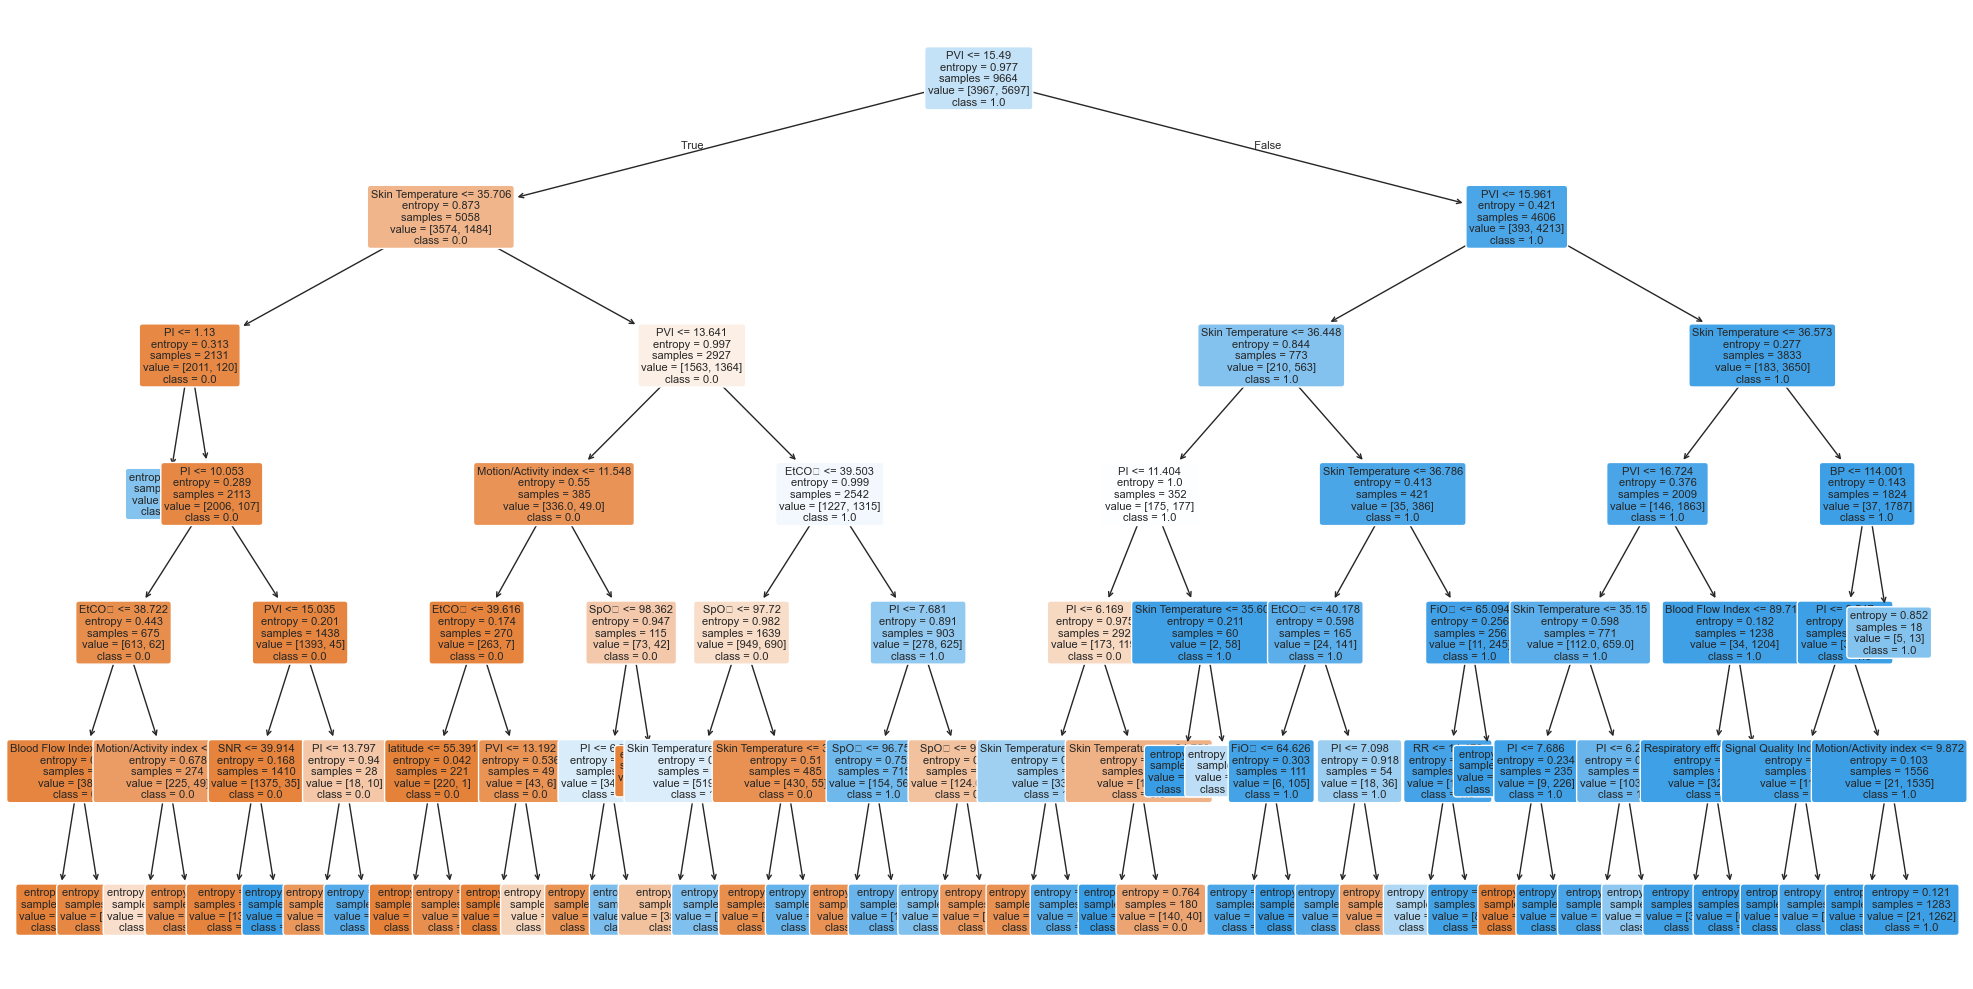

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=feature_names,
    class_names=[str(c) for c in np.unique(y_train)],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.tight_layout()
plt.show()

## 3.2 E

In [16]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df

,model,accuracy_train,precision_train,recall_train,accuracy_test,precision_test,recall_test
0,ID3Classifier,0.870861,0.849709,0.948745,0.862640,0.851784,0.938347
1,DecisionTreeClassifier,0.902111,0.907112,0.929085,0.892842,0.900592,0.926829
2,LogisticRegression,0.838473,0.857168,0.871160,0.839470,0.864123,0.874661


## 3.3 A

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid={ "max_depth": [2, 3, 5, 7, 9, 12, None], "min_samples_split": [2, 5, 10, 20], "min_samples_leaf": [1, 2, 4, 6, 8], },
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

In [18]:
grid_dt.fit(X_train_tr, y_train)

best_dt = grid_dt.best_estimator_

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [19]:
print("Best hyperparameters for DecisionTree:")
print(grid_dt.best_params_)
print("CV accuracy (mean):", grid_dt.best_score_)

Best hyperparameters for DecisionTree:
{'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 20}
CV accuracy (mean): 0.906561101239344


In [20]:
y_train_best_dt = best_dt.predict(X_train_tr)
y_test_best_dt  = best_dt.predict(X_test_tr)

print_metrics("Best DecisionTreeClassifier (Train)",  y_train, y_train_best_dt)
print_metrics("Best DecisionTreeClassifier (Test)",  y_test, y_test_best_dt)

=== Best DecisionTreeClassifier (Train) ===
Accuracy:  0.9326365894039735
Precision (macro): 0.9316239042212419
Recall (macro):    0.9288945322519704

=== Best DecisionTreeClassifier (Test) ===
Accuracy:  0.9035995035167563
Precision (macro): 0.9010227427123829
Recall (macro):    0.8952625644747414



Using the GridSearchCV method, we automatically searched through various combinations of decision tree hyperparameters and selected those that achieved the highest accuracy during 5-fold cross-validation.
The optimized tree achieved significantly better results than the original manual settings - accuracy on training data (approximately 0.93) and on test data (approximately 0.90).
The small difference between train and test shows that the model generalizes well and has not overfit.

## 3.3 B

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    criterion="entropy",
    max_depth=9,
    min_samples_split=20,
    min_samples_leaf=8,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_tr, y_train)

y_train_rf = rf.predict(X_train_tr)
y_test_rf  = rf.predict(X_test_tr)

In [32]:
print_metrics("RandomForestClassifier (Train)",  y_train, y_train_rf)
print_metrics("RandomForestClassifier (Test)",  y_test, y_test_rf)

=== RandomForestClassifier (Train) ===
Accuracy:  0.9287044701986755
Precision (macro): 0.9274693402391243
Recall (macro):    0.9249087798632203

=== RandomForestClassifier (Test) ===
Accuracy:  0.9056681836988002
Precision (macro): 0.902095780568668
Recall (macro):    0.8988822938176246



We trained RandomForestClassifier on the same data as the optimized DecisionTree so that we could directly compare their performance. The model achieved very good results. It achieved an accuracy of 0.9287 on the training set and 0.9057 on the test set. Both precision (0.9021) and recall (0.8989) on the test data were also balanced and high.

These results show that Random Forest generalizes slightly better than a single decision tree, which is expected for a method that combines a large number of trees. The model is stable, reliable, and provides slightly better performance than our best DecisionTree.

## 3.3 C

In [23]:
from sklearn.model_selection import cross_val_score

cv_scores_rf = cross_val_score(
    rf,
    X_train_tr,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

print("CV accuracy scores (RF):", cv_scores_rf)
print("Mean CV accuracy:", cv_scores_rf.mean())
print("Std CV accuracy :", cv_scores_rf.std())

CV accuracy scores (RF): [0.89912054 0.90377651 0.91101914 0.89549922 0.90890269]
Mean CV accuracy: 0.9036636215924998
Std CV accuracy : 0.005811389912529653


We used 5-fold cross-validation to verify the stability of the RandomForestClassifier model. The accuracy values obtained were very consistent, ranging from approximately 0.895 to 0.911. The average CV accuracy of the model was 0.9037 and the standard deviation was only 0.0058.

Such low variability between individual folds means that Random Forest performs stably even with different data distributions. The model is therefore not dependent on a specific training/testing split, and its generalization is reliable.

## 3.3 D

In [24]:
train_acc_rf = accuracy_score(y_train, y_train_rf)
test_acc_rf  = accuracy_score(y_test,  y_test_rf)

train_prec_rf = precision_score(y_train, y_train_rf, average='binary')
test_prec_rf  = precision_score(y_test,  y_test_rf, average='binary')

train_rec_rf = recall_score(y_train, y_train_rf, average='binary')
test_rec_rf  = recall_score(y_test,  y_test_rf, average='binary')

In [25]:
print("RandomForest – TRAIN vs TEST comparison:")
print(f"Accuracy train = {train_acc_rf:.3f}, test = {test_acc_rf:.3f}, diff = {train_acc_rf - test_acc_rf:.3f}")
print(f"Precision train = {train_prec_rf:.3f}, test = {test_prec_rf:.3f}, diff = {train_prec_rf - test_prec_rf:.3f}")
print(f"Recall   train = {train_rec_rf:.3f}, test = {test_rec_rf:.3f}, diff = {train_rec_rf - test_rec_rf:.3f}")

print("\nCross-validation (cv=5) – RF:")
print("CV scores       :", cv_scores_rf)
print("Mean CV accuracy:", cv_scores_rf.mean())
print("Std  CV accuracy:", cv_scores_rf.std())

RandomForest – TRAIN vs TEST comparison:
Accuracy train = 0.929, test = 0.906, diff = 0.023
Precision train = 0.934, test = 0.917, diff = 0.017
Recall   train = 0.946, test = 0.930, diff = 0.017

Cross-validation (cv=5) – RF:
CV scores       : [0.89912054 0.90377651 0.91101914 0.89549922 0.90890269]
Mean CV accuracy: 0.9036636215924998
Std  CV accuracy: 0.005811389912529653


From the previous sections, we can see that the RandomForestClassifier model achieved the best results, so we will focus on it in section 3.3 D. We compared the metrics on training and testing data: accuracy 0.929 (train) vs. 0.906 (test), a difference of 0.023, with differences in precision and recall of approximately 0.017.

These values show that although the model learns very well on training data, it does not lose its ability to generalize to the test set. Cross-validation with an average accuracy of 0.9037 and low standard deviation confirms this conclusion. Based on this, we can say that our best model (RandomForest) is set up to be without significant overfitting.

## 3.4 A

### Data preprocessing strategies

In preprocessing, we focused on two main tasks: working with missing values and correctly dividing the data into training and test sets.
The dataset contained missing values that could negatively affect model training and lead to unreliable predictions. Therefore, we used SimpleImputer with a median strategy, which is resistant to outliers and preserves a realistic distribution of attributes.

After preprocessing, we saw that the models achieved stable results, with no extreme fluctuations between training and testing accuracy. This means that the chosen preprocessing was effective for this dataset and directly contributed to better classification.

## 3.4 B

### Data transformation (scaling, transformer, etc.)

The dataset contained attributes with different ranges and distributions. In such cases, it is important to perform an appropriate transformation so that the models can work effectively with all features. We used two forms of transformation:

- QuantileTransformer for attributes with skewed distribution (feature indexes 13 and 20), converting these features to approximately normal distribution.

- StandardScaler for other numerical attributes so that all features had a comparable scale.

These transformations allowed the models to converge faster and more stably and directly contributed to higher accuracy. In particular, LogisticRegression does not work well without transformation – in our case, the transformation significantly improved its performance. For decision trees and RandomForest, transformation is not strictly necessary, but for the sake of pipeline consistency, we used it for the entire dataset.

## 3.4 C

### Attribute selection, algorithm selection, hyperparameter tuning, ensemble learning

When selecting approaches, we used all available attributes and compared several classification algorithms: our own ID3, the DecisionTreeClassifier library, LogisticRegression, and the ensemble RandomForestClassifier. We also used:

- Hyperparameter tuning using GridSearchCV for the decision tree. This method systematically searched through parameter combinations and found the optimal settings, which significantly increased the accuracy of the model (to approximately 0.90).

- Ensemble learning (RandomForestClassifier), which combines a large number of trees, thereby reducing the variability of individual trees. This model achieved the best results of all — test accuracy of approximately 0.9057, precision of 0.9021, and recall of 0.8989.

With this approach, we ensured that we did not choose a random model, but a solution that demonstrably maximizes classification accuracy on our dataset.

## 3.4 D

### Which model is our best model for deployment?

Based on all tests, we chose RandomForestClassifier as our best model.
The reasons are clear:

- It achieved the highest accuracy on the test data (≈ 0.906).

- The difference between training and testing accuracy was small (0.929 → 0.906), indicating that the model was not overtrained.

- Precision and recall were also stable and high.

- Cross-validation (cv=5) confirmed stability: average accuracy of 0.9037, very low deviation of 0.0058.

These results prove that RandomForestClassifier has the best generalization, the highest robustness, and is the most suitable candidate for real-world deployment.

## 3.4 E

### What is the data pipeline for building it in production?

In order for our best model to work in production, it is necessary to follow a consistent pipeline.
This consists of the following steps:

1. Input data collection – new observations must have the same attributes as the original observation dataset.

2. Imputation of missing values – we apply exactly the same trained SimpleImputer.

3. Data transformation –

    - QuantileTransformer (trained during training) for specific attributes 13 and 20,

    - StandardScaler for other attributes.

4. Model prediction – the transformed data is passed to the trained RandomForestClassifier, which makes a prediction.

5. (Optional) Monitoring – monitoring the accuracy of the model with new data.

This pipeline ensures that the data processing in production will be identical to the one we used during training. This is necessary for the model to maintain the same accuracy after deployment.